In [36]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

## Read database

In [59]:
dbfile = 'os-sqlite3-data/database.db'
table_name = 'selected_books'
query = f"SELECT * FROM {table_name}"
with sqlite3.connect(dbfile) as connection:
    df = pd.read_sql_query(query, connection)
df.head()

,id,title,authors,year,isbn,is_found,labels_set,search_count,search_terms,search_begin_time_utc,search_end_time_utc,abandon_time_utc,uid
0,1,Tähtikissa,"Meripaasi, Helena",2018.0,9.789512e+12,1,a,1,"kissa,",2023-09-12T13:42:09.473Z,2023-09-12T13:42:13.577Z,None,3666a06e-ee73-4983-8f66-8a270a9fdd03
1,2,Törni iskee,"Sirén, Esa",2016.0,9.789512e+12,1,a,2,"jatkosota, taistelut,",2023-09-12T13:42:09.473Z,2023-09-12T13:42:37.770Z,None,3666a06e-ee73-4983-8f66-8a270a9fdd03
2,3,Tuntematon sotilas,"Linna, Väinö",1991.0,9.789512e+12,1,a,1,"taistelut,",2023-09-12T13:42:09.473Z,2023-09-12T13:42:46.317Z,None,3666a06e-ee73-4983-8f66-8a270a9fdd03
3,4,täällä pohjantähden alla,,NaN,NaN,0,a,1,None,2023-09-12T13:42:09.473Z,None,2023-09-12T13:43:05.534Z,3666a06e-ee73-4983-8f66-8a270a9fdd03
4,5,Gelatine-tädin salamatka,"Teresina, Bourbon-Sienan Suurherttuatar; Teres...",1949.0,9.789512e+12,1,b,1,"raivaus,",2023-09-12T13:43:53.097Z,2023-09-12T13:44:04.374Z,None,3666a06e-ee73-4983-8f66-8a270a9fdd03


In [88]:
# Convert timestamps in string format to datetime
df['search_begin_time_utc'] = pd.to_datetime(df['search_begin_time_utc'])
df['search_end_time_utc'] = pd.to_datetime(df['search_end_time_utc'])
df['search_abandon_time_utc'] = pd.to_datetime(df['abandon_time_utc'])

# Calculate durations in seconds
df['duration_to_find'] = (df['search_end_time_utc'] - df['search_begin_time_utc']).dt.total_seconds()
df['duration_to_abandon'] = (df['search_abandon_time_utc'] - df['search_begin_time_utc']).dt.total_seconds()

## Results

In [96]:
df.groupby(by='labels_set').describe()

id                                                     year  \
           count       mean       std  min   25%   50%    75%   max count   
labels_set                                                                  
a           14.0   8.214286  4.560340  1.0   4.5   8.5  11.75  15.0   7.0   
b           11.0  19.090909  5.485518  5.0  17.5  20.0  22.50  25.0   4.0   

                         ... duration_to_find           duration_to_abandon  \
                   mean  ...              75%       max               count   
labels_set               ...                                                  
a           1984.857143  ...        850.99700  1282.685                 7.0   
b           1953.500000  ...        394.33925   794.840                 7.0   

                                                                            \
                   mean         std      min      25%       50%        75%   
labels_set                                                                   
a           1118.373714  580.281702   56.061  890.025  1232.706  1517.7720   
b            825.549571  421.123474  230.999  540.889   755.749  1181.4035   

                      
                 max  
labels_set            
a           1724.255  
b           1347.514  

[2 rows x 56 columns]

In [95]:
df.groupby(by='labels_set')[['is_found']].sum()

,is_found
labels_set,
a,7
b,4


In [90]:
df.groupby(by='labels_set')[['is_found', 'duration_to_find', 'duration_to_abandon']].mean()

,is_found,duration_to_find,duration_to_abandon
labels_set,,,
a,0.500000,443.861571,1118.373714
b,0.363636,284.495500,825.549571


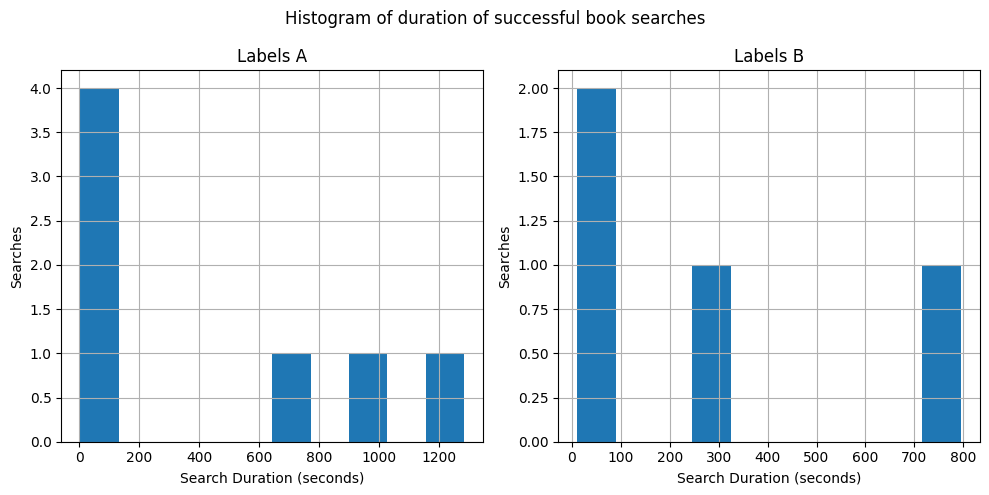

In [87]:
# Create a subplot with two histograms
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed

# Subplot for 'labels_set' == 'a'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
df[df.labels_set == 'a'].duration_to_find.hist()
plt.xlabel('Search Duration (seconds)')
plt.ylabel('Searches')
plt.title('Labels A')

# Subplot for 'labels_set' == 'b'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
df[df.labels_set == 'b'].duration_to_find.hist()
plt.xlabel('Search Duration (seconds)')
plt.ylabel('Searches')
plt.title('Labels B')

plt.suptitle('Histogram of duration of successful book searches')
plt.tight_layout()  # Adjusts subplot parameters for better spacing
plt.show()

In [ ]:
df.groupby(by='labels_set').agg({
    "is_found": 'mean',
    "duration_to_find": 'mean',
    "duration_to_abandon": 'mean',

In [64]:
df_found = df[df.is_found == 1]
df_found['search_duration'] = df_found['search_end_time_utc'] - df_found['search_begin_time_utc']

/tmp/ipykernel_133585/105496224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_found['search_duration'] = df_found['search_end_time_utc'] - df_found['search_begin_time_utc']


In [65]:
df_not_found = df[df.is_found == 0]
df_not_found['search_duration'] = df_not_found['search_abandon_time_utc'] - df_not_found['search_begin_time_utc']

/tmp/ipykernel_133585/107719388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_found['search_duration'] = df_not_found['search_abandon_time_utc'] - df_not_found['search_begin_time_utc']
